# Working with geodatabase (shapefiles and rasters) and map plots of raster statistics

In [547]:
%matplotlib inline
from __future__ import print_function, division
import seaborn as sns
sns.set(rc={'image.cmap': 'cubehelix'})
sns.set_context('poster')

import pandas as pd
import os
import glob
import pip
import netCDF4, numpy
import numpy as np
np.random.seed(0)
from numpy import linspace, meshgrid

# GIS modules
import geopandas as gp
import folium
import postgis
import imageio
from osgeo import gdal
import rasterstats
import fiona
"""
from osgeo import gdal
from osgeo import gdal_array
from osgeo import osr""" 

# Plotting functions
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
from matplotlib.patches import PathPatch
from matplotlib.colors import rgb2hex, Normalize
from matplotlib.cm import ScalarMappable
from matplotlib.colorbar import ColorbarBase
import matplotlib.colors
from matplotlib.mlab import griddata

# Geodatabase (geopandas)

In [548]:
# Open the Counties shape file and inspect the contents
counties_file = "/home2/svimal/Github/CA_drought/data/Spatial/CA_counties/CA_counties.shp"
counties_gp = gp.GeoDataFrame.from_file(counties_file)
counties_gp.head(2)
print(counties_gp.columns)
lts = []
lns = []
for i in range(len(counties_gp["INTPTLAT"])):
    lts.append(float(counties_gp["INTPTLAT"][i]))
    lns.append(float(counties_gp["INTPTLON"][i]))
    #len(counties_gp["INTPTLON"]))
print(lts[0:5], lns[0:5])

Failed to auto identify EPSG: 7
Index([     u'ALAND',     u'AWATER',     u'CBSAFP',    u'CLASSFP',
         u'COUNTYFP',   u'COUNTYNS',      u'CSAFP',   u'FUNCSTAT',
            u'GEOID',   u'INTPTLAT',   u'INTPTLON',       u'LSAD',
         u'METDIVFP',      u'MTFCC',       u'NAME',   u'NAMELSAD',
         u'OBJECTID',    u'STATEFP', u'Shape_Area', u'Shape_Leng',
        u'geoid_num',   u'geometry'],
      dtype='object')
[39.5769252, 38.4500114, 34.5370572, 38.1838996, 34.3587415] [-120.5219926, -121.3404409, -120.0399729, -120.5614415, -119.1331432]


# NetCDF data

In [21]:
# The NetCDF I/O files from VIC model archive
filenames = glob.glob("/home2/svimal/Data/VIC_Fluxes/*")
for fname in filenames:
    #fname = "/home/solo/Desktop/Data/VIC_archive/cali1/ncdata.201401.nc"
    data = netCDF4.Dataset(fname, "r")
    print(data.variables)

OrderedDict([(u'time', <type 'netCDF4._netCDF4.Variable'>
float64 time(time)
    _FillValue: 9.96921e+36
    units: days since 0001-1-1 0:0:0
unlimited dimensions: time
current shape = (31,)
filling on), (u'lat', <type 'netCDF4._netCDF4.Variable'>
float64 lat(lat)
    _FillValue: 9.96921e+36
    units: degrees_north
unlimited dimensions: 
current shape = (350,)
filling on), (u'lon', <type 'netCDF4._netCDF4.Variable'>
float64 lon(lon)
    _FillValue: 9.96921e+36
    units: degrees_east
unlimited dimensions: 
current shape = (310,)
filling on), (u'mask', <type 'netCDF4._netCDF4.Variable'>
float64 mask(lat, lon)
    _FillValue: 9.96921e+36
    comment: 0 indicates grid cell is not active
unlimited dimensions: 
current shape = (350, 310)
filling on), (u'Prec', <type 'netCDF4._netCDF4.Variable'>
float32 Prec(time, lat, lon)
    _FillValue: 9.96921e+36
    units: mm/day
unlimited dimensions: time
current shape = (31, 350, 310)
filling on), (u'Evap', <type 'netCDF4._netCDF4.Variable'>
float32

In [104]:
# Inspect the variables inside data
print("Time, Lat, Lon, Soil_liquid")
print(len(data["time"][:]), len(data["lat"][:]), len(data["lon"][:]),  len(data["Soil_liquid"][:]))

Time, Lat, Lon, Soil_liquid
30 350 310 30


In [389]:
# data.variables["Soil_liquid"][29][2][349][309] # #data.variables["Soil_liquid"][time][lat][lon]
data_lists = []
for soil_layer in [0]:#,1,2]:
    for time in range(len(data["time"][:])):
        data_list = []
        if time%20==0:
            for lat in range(len(data["lat"][:])):
                for lon in range(len(data["lon"][:])):
                    d = float(data.variables["Soil_liquid"][time][soil_layer][lat][lon])
                    if numpy.isnan(float(d)) == True:
                        data_list.append(0)
                    else:
                        data_list.append(d)
            data_lists.append(data_list)
        else:
            pass

/home2/Software/lib/python2.7/site-packages/ipykernel_launcher.py:9: UserWarning: Warning: converting a masked element to nan.
  if __name__ == '__main__':


In [254]:
# Length of the data lists ()
len(data_lists), len(data_lists[0])

(2, 108500)

In [109]:
# Make vectors for lat and lon 
lats, lons = [], []
for lat in range(350):
    for lon in range(310):
        lats.append(lat)
        lons.append(lon)
len(lats), len(lons)

(108500, 108500)

# NetCDF vectors to raster images 

In [112]:
# Interpolation surface that uses lat, lon and Z values
def grid(x, y, z, resX=100, resY=100):
    "Convert 3 column data to matplotlib grid"
    xi = linspace(min(x), max(x), resX)
    yi = linspace(min(y), max(y), resY)
    Z = griddata(x, y, z, xi, yi, interp='linear')
    X, Y = meshgrid(xi, yi)
    return X, Y, Z

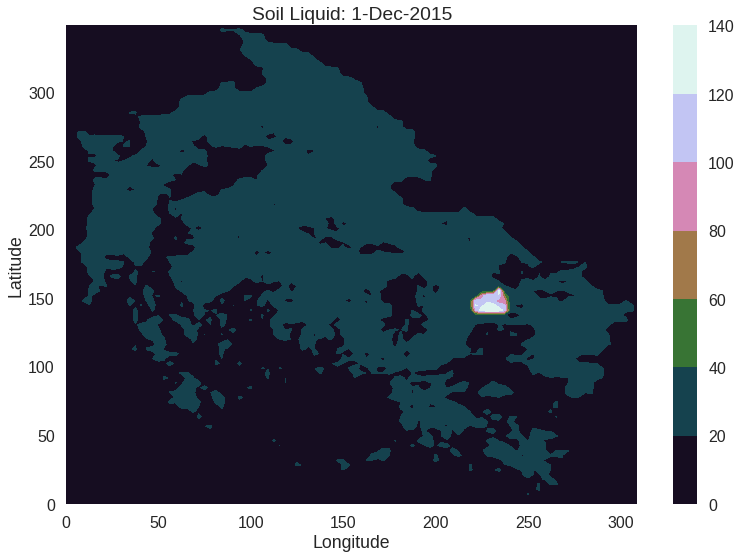

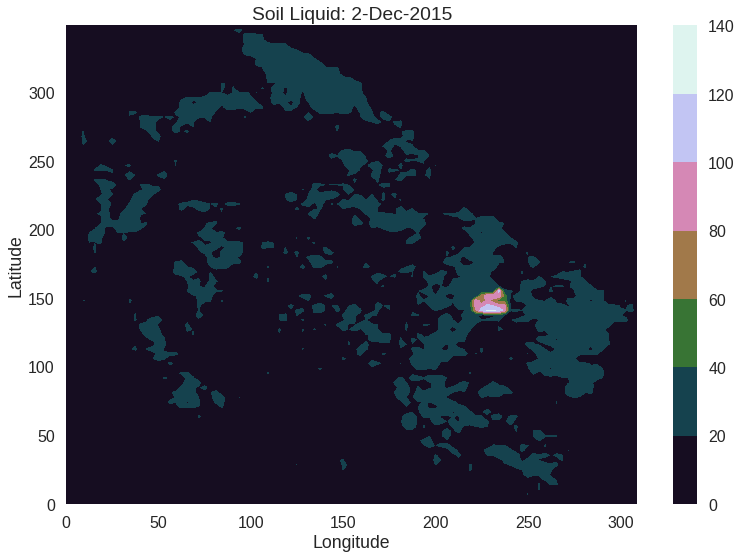

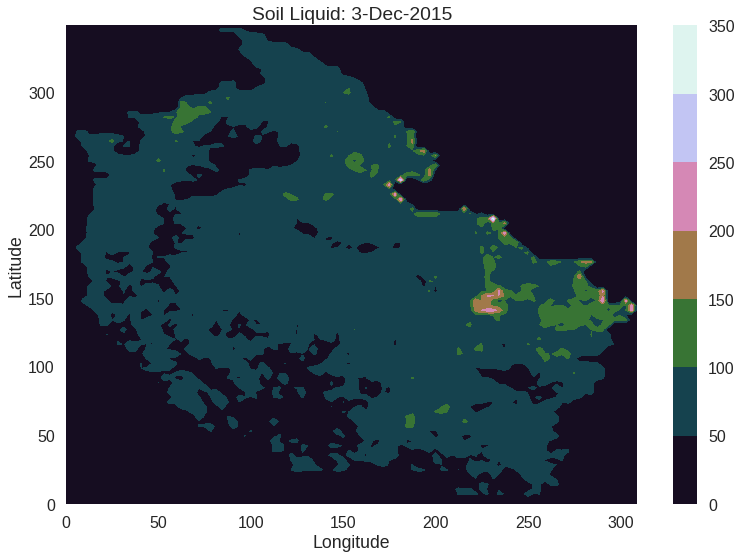

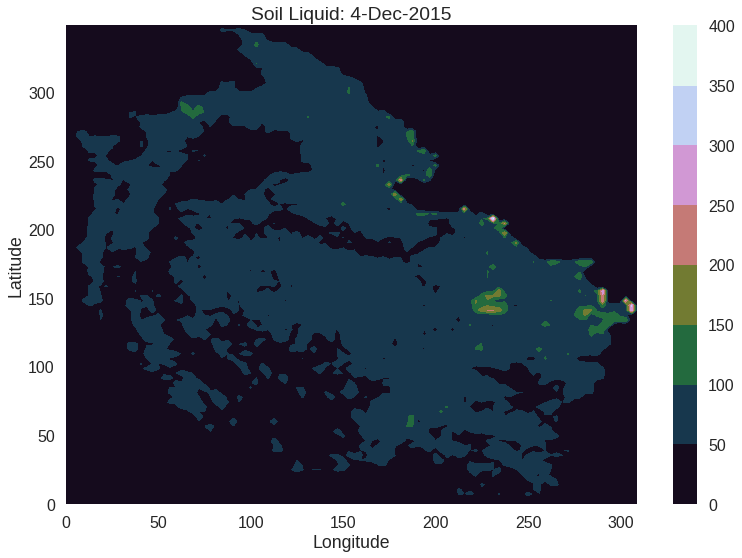

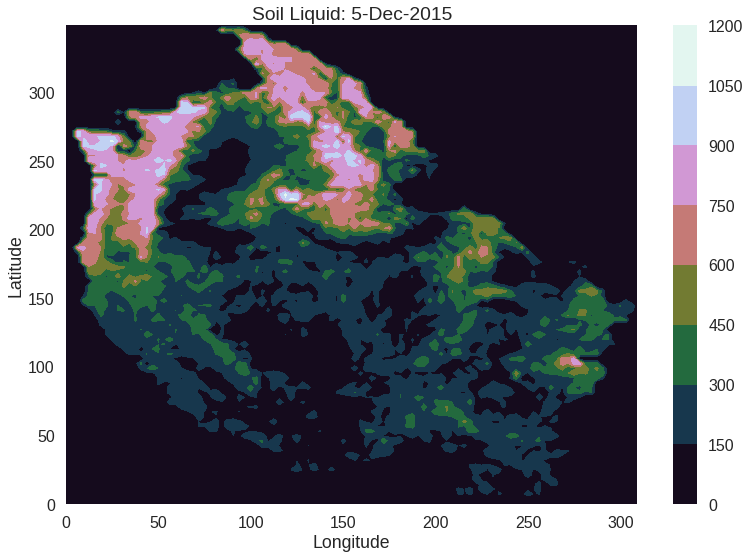

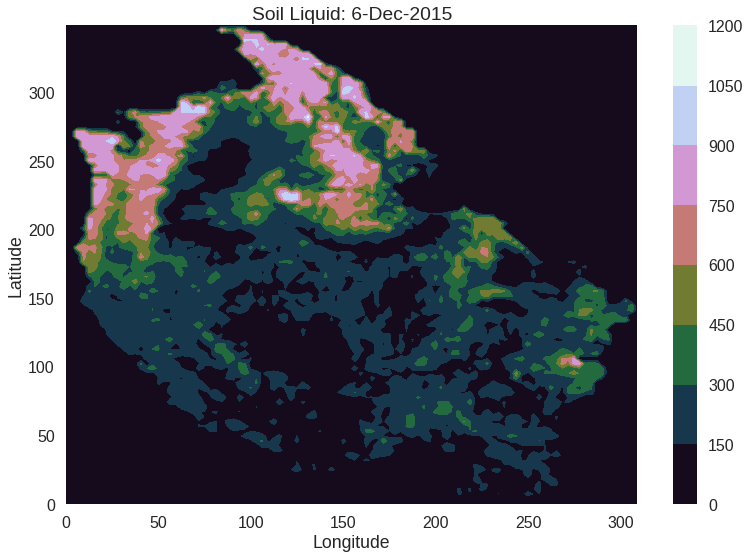

Soil_Liquid_5.png


'/home2/svimal/Github/UCLA-Hydro/MRPI'

In [134]:
# Create the interpolated surface of the VIC variables for each lat and lon and Z (soil layer example)
month, year = "Dec", "2015"
filenames = []
for i in range(len(data_lists)):
    day = str(i+1) + ""
    z = data_lists[i]
    x = lons
    y = lats
    X, Y, Z = grid(x, y, z)
    plt.figure(i)
    plt.contourf(X, Y, Z)
    plt.colorbar()
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.title("Soil Liquid: " + str(day) + "-" + str(month) + "-" + str(year))
    #fname = "swe_" + str(i) + ".png"
    fname = "Soil_Liquid_" + str(i) + ".png"
    plt.savefig(fname)
    filenames.append(fname)
    plt.show()
else:
    pass
print(fname)
os.getcwd()

# Creating GeoTIFFs and .ASCII files

In [550]:
# Create an ascii grid from one time slice of data for all lat and long

ncols = len(data.variables["lon"][:])
nrows = len(data.variables["lat"][:])
xllcorner = min(data.variables["lon"][:]) 
yllcorner = min(data.variables["lat"][:])
cell_size =  abs(data.variables["lat"][1] - data.variables["lat"][0])
nodata_value = -9999
myArray = np.reshape(data_lists[0], (nrows, ncols))

with open("sm.asc", "w") as f:
    f.write("NCOLS " + str(ncols) + "\n")
    f.write("NROWS " + str(nrows) + "\n")
    f.write("XLLCORNER " + str(xllcorner) + "\n") 
    f.write("YLLCORNER " + str(yllcorner) + "\n")
    f.write("CELLSIZE " + str(cell_size) + "\n")
    f.write("NODATA_VALUE = -9999\n")
    data_2d =  np.reshape(data_lists[0], (nrows, ncols))
    for line in data_2d:
        f.write(str(list(line)).strip("[").strip("]")[1:].strip("\n") + "\n")

os.getcwd()

'/home2/svimal/Github/CA_drought/data/Spatial/CA_counties'

In [ ]:
# Create a GIF from the different time steps of the VIC I/O variables
images = []
for filename in filenames:
    images.append(imageio.imread(filename))
# Create GIF files from the snow water equivalent
#imageio.mimsave('SWE_GIF.gif', images, duration=0.5)
imageio.mimsave('Soil_Liquid_GIF.gif', images, duration=0.5)
os.getcwd()

In [553]:
# View the GIF
from IPython.display import Image
Image(url='Soil_Liquid_GIF.gif')

# Working with VIC data

/home2/Software/lib/python2.7/site-packages/ipykernel_launcher.py:25: UserWarning: Warning: converting a masked element to nan.


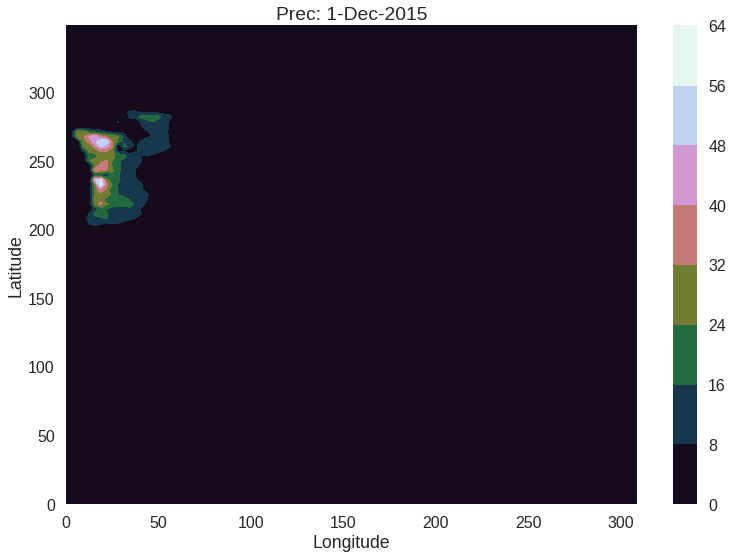

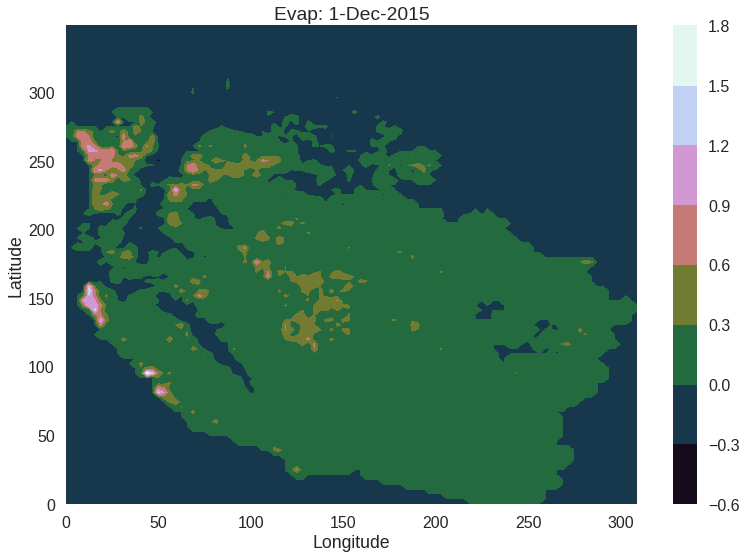

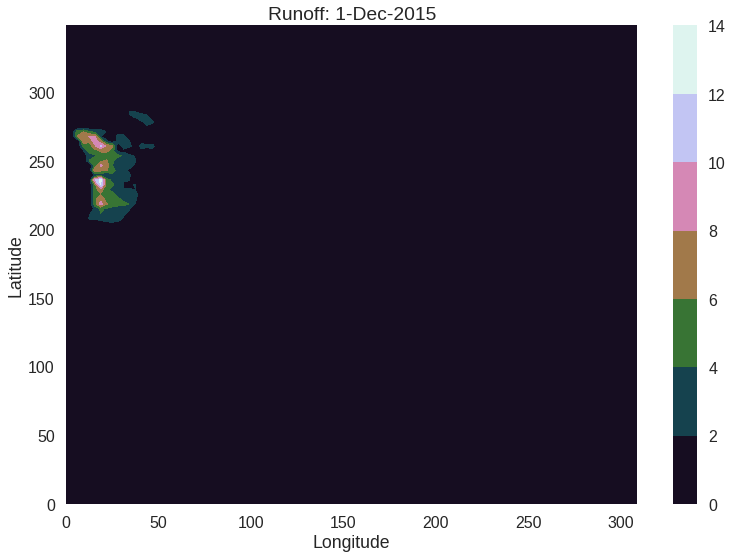

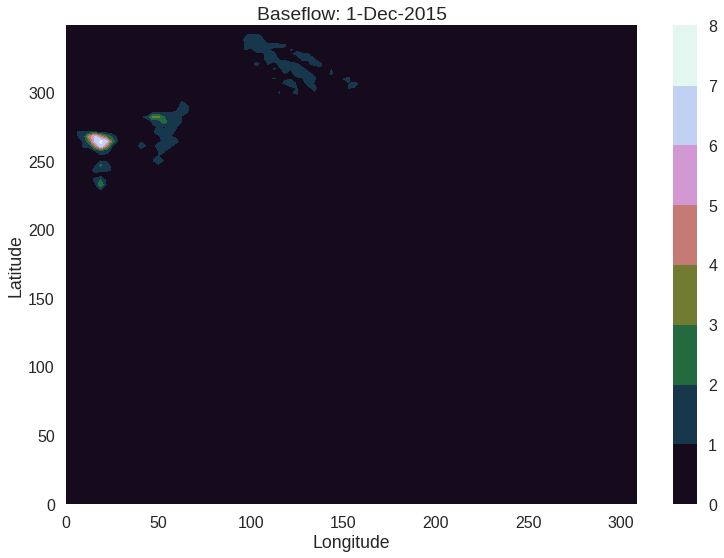

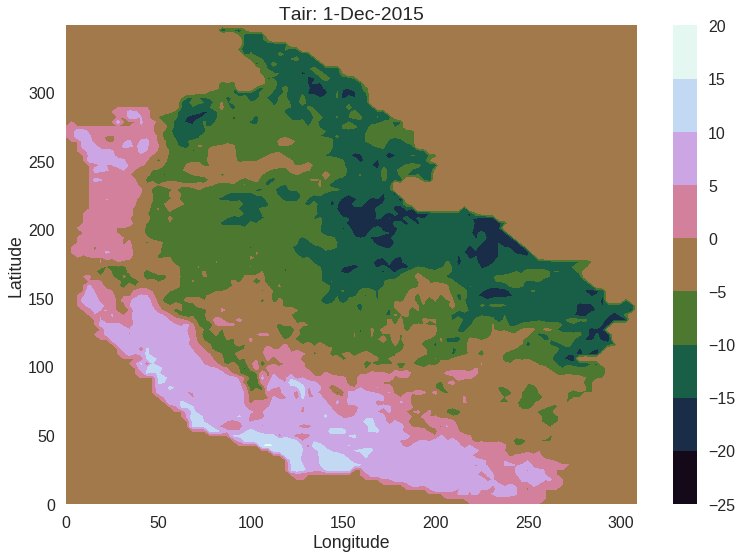

In [148]:
# Other input and uutput fluxes from VIC: Precipitation, Runoff, Baseflow, Air Temperature:
lats, lons = [], []
for lat in range(len(data["lat"][:])):
    for lon in range(len(data["lon"][:])):
        lats.append(lat)
        lons.append(lon)
len(lats), len(lons)

fname = "/home2/svimal/Data/VIC_Fluxes/fluxes.2015-12.nc"
data = netCDF4.Dataset(fname, "r")
data.variables

variables = ["Prec", "Evap", "Runoff", "Baseflow", "Tair", "Soil_liquid", "SWE"]
month, year = "Dec", "2015"
day=1
data_lists = []
filenames=[]
for i, var in enumerate(variables):
    for time in range(len(data["time"][0:1])):
        data_list = []
        if time==0:
            try:
                for lat in range(len(data["lat"][:])):
                    for lon in range(len(data["lon"][:])):
                        d = float(data.variables[var][time][lat][lon])
                        if numpy.isnan(d) == True:
                            data_list.append(0)
                        else:
                            data_list.append(d)
                data_lists.append(data_list)

                z = data_lists[i]
                x = lons
                y = lats
                X, Y, Z = grid(x, y, z)
                plt.figure(i)
                plt.contourf(X, Y, Z)
                plt.colorbar()
                plt.xlabel("Longitude")
                plt.ylabel("Latitude")
                plt.title(str(var)+": " + str(day) + "-" + str(month) + "-" + str(year))
                #fname = "swe_" + str(i) + ".png"
                fname = str(var)+ "_" + str(i) + ".png"
                plt.savefig(fname)
                filenames.append(fname)
                plt.show()
            except:
                pass
        else:
            pass

# Working with shapefiles

In [249]:
# Dissolve - merge the counties to form a single state shapefile that can be used to clip out CA VIC data from western US

# define your directories and file names
dir_input = '/home2/svimal/Github/CA_drought/data/Spatial/CA_counties/'
name_in = 'CA_counties_WGS.shp'
dir_output = '/home2/svimal/Github/CA_drought/data/Spatial/CA_counties/'
name_out = 'CA.shp'

# create a dictionary
states = {}
# open your file with geopandas
counties = gp.GeoDataFrame.from_file(dir_input + name_in)

for i in range(len(counties)):
    state_id = counties.at[i, 'STATEFP']
    county_geometry = counties.at[i, 'geometry']
    # if the feature's state doesn't yet exist, create it and assign a list
    if state_id not in states:
        states[state_id] = []
    # append the feature to the list of features
    states[state_id].append(county_geometry)

# create a geopandas geodataframe, with columns for state and geometry
states_dissolved = gp.GeoDataFrame(columns=['state', 'geometry'], crs=counties.crs)

# iterate your dictionary
for state, county_list in states.items():
    # create a geoseries from the list of features
    geometry = gp.GeoSeries(county_list)
    # use unary_union to join them, thus returning polygon or multi-polygon
    geometry = geometry.unary_union
    # set your state and geometry values
    states_dissolved.set_value(state, 'state', state)
    states_dissolved.set_value(state, 'geometry', geometry)

# save to file
states_dissolved.to_file(dir_output + name_out, driver="ESRI Shapefile")

In [157]:
# compute map projection coordinates for lat/lon grid.
# https://matplotlib.org/basemap/api/basemap_api.html?highlight=imshow#mpl_toolkits.basemap.Basemap.imshow

# Visualization of data on maps

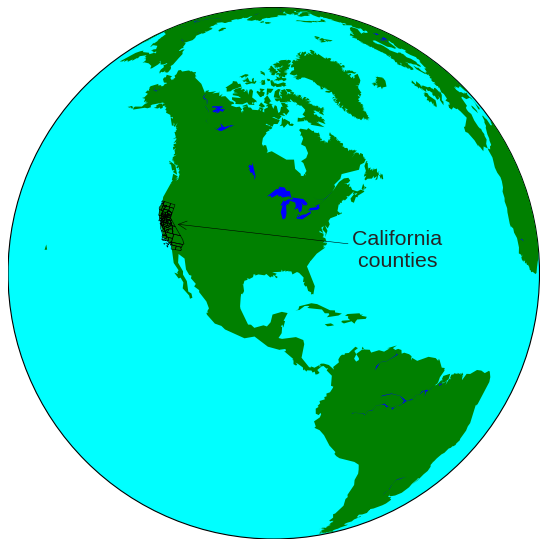

In [559]:
# 3D Globe View
plt.figure(dpi=80)
map = Basemap(projection='ortho', lat_0=30, lon_0=-90)
#llcrnrx=min(data.variables["lon"][:]),llcrnry=min(data.variables["lat"][:]),urcrnrx=max(data.variables["lon"][:]),urcrnry=max(data.variables["lat"][:])

map.drawmapboundary(fill_color='aqua')
map.fillcontinents(color='green',lake_color='blue')
map.readshapefile("/home2/svimal/Github/CA_drought/data/Spatial/CA_counties/CA_counties_WGS", "counties")
#map.drawcoastlines()
x, y = map(-118, 38)
#x2, y2 = (-90, 10)
#plt.annotate('Barcelona', xy=(x, y),  xycoords='data', xytext=(x2, y2), textcoords='offset points',color='r', arrowprops=dict(arrowstyle="fancy", color='g'))
x2, y2 = map(-70, 30)
plt.annotate('California \n counties', xy=(x, y),  xycoords='data', xytext=(x2, y2), textcoords='data',
                arrowprops=dict(arrowstyle="->"))
map.contourf(data=Z,x=X, y=Y)
plt.show()

# Zonal Statistics

In [230]:
# Open Shapefile
driver = ogr.GetDriverByName('ESRI Shapefile')
shp = driver.Open(input_zone_polygon)

In [237]:
# Calculates statistics (mean) on values of a raster within the zones of an polygon shapefile

def zonal_stats(input_value_raster, input_zone_polygon):

    # Open data
    raster = gdal.Open(input_value_raster)
    driver = ogr.GetDriverByName('ESRI Shapefile')
    shp = driver.Open(input_zone_polygon)
    lyr = shp.GetLayer()

    # get raster georeference info
    transform = raster.GetGeoTransform()
    xOrigin = transform[0]
    yOrigin = transform[3]
    pixelWidth = transform[1]
    pixelHeight = transform[5]

    # reproject geometry to same projection as raster
    sourceSR = lyr.GetSpatialRef()
    targetSR = osr.SpatialReference()
    targetSR.ImportFromWkt(raster.GetProjectionRef())
    coordTrans = osr.CoordinateTransformation(sourceSR,targetSR)
    feat = lyr.GetNextFeature()
    geom = feat.GetGeometryRef()
    geom.Transform(coordTrans)
    # Get extent of geometry
    ring = geom.GetGeometryRef(0)
    numpoints = ring.GetPointCount()
    pointsX = []; pointsY = []
    for p in range(numpoints):
            lon, lat, z = ring.GetPoint(p)
            pointsX.append(lon)
            pointsY.append(lat)
    xmin = min(pointsX)
    xmax = max(pointsX)
    ymin = min(pointsY)
    ymax = max(pointsY)

    # Specify offset and rows and columns to read
    xoff = int((xmin - xOrigin)/pixelWidth)
    yoff = int((yOrigin - ymax)/pixelWidth)
    xcount = int((xmax - xmin)/pixelWidth)+1
    ycount = int((ymax - ymin)/pixelWidth)+1

    # create memory target raster
    target_ds = gdal.GetDriverByName('MEM').Create('', xcount, ycount, gdal.GDT_Byte)
    target_ds.SetGeoTransform((
        xmin, pixelWidth, 0,
        ymax, 0, pixelHeight,
    ))

    # create for target raster the same projection as for the value raster
    raster_srs = osr.SpatialReference()
    raster_srs.ImportFromWkt(raster.GetProjectionRef())
    target_ds.SetProjection(raster_srs.ExportToWkt())

    # rasterize zone polygon to raster
    gdal.RasterizeLayer(target_ds, [1], lyr, burn_values=[1])

    # read raster as arrays
    banddataraster = raster.GetRasterBand(1)
    dataraster = banddataraster.ReadAsArray(xoff, yoff, xcount, ycount).astype(numpy.float)

    bandmask = target_ds.GetRasterBand(1)
    datamask = bandmask.ReadAsArray(0, 0, xcount, ycount).astype(numpy.float)

    # mask zone of raster
    zoneraster = numpy.ma.masked_array(dataraster,  numpy.logical_not(datamask))

    # calculate mean of zonal raster
    return numpy.mean(zoneraster)

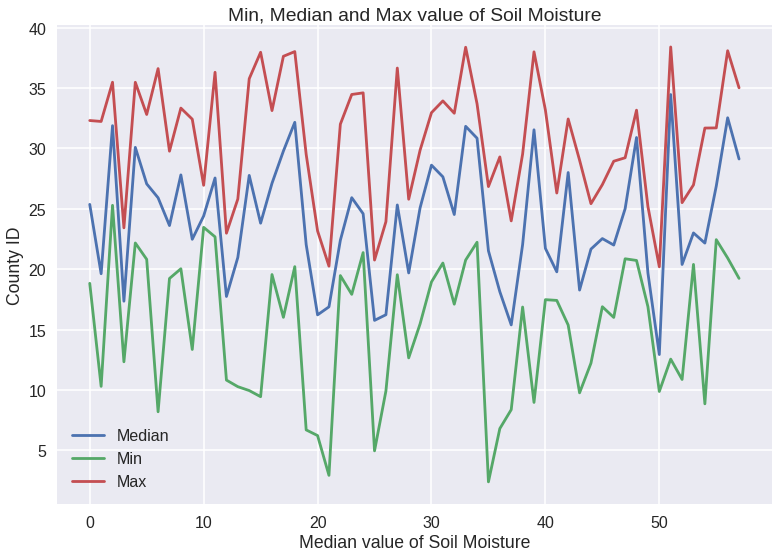

In [534]:
# Raster Stats from the county shapefiles and the Soil Moisture Layer

shp = '/home2/svimal/Github/CA_drought/data/Spatial/CA_counties/CA_counties_WGS.shp'
ras = '/home2/svimal/Github/UCLA-Hydro/MRPI/sm_clipped.tif'

stats = rasterstats.zonal_stats(shp, ras, stats="min max median majority sum")
#print(stats)
len(stats)
type(stats)

medians = []
for i in range(len(stats)):
    medians.append(stats[i]["median"])    
# medians
plt.xlabel("Median value of Soil Moisture"); plt.ylabel("County ID")
plt.plot(medians, label="Median")

maxs = []
for i in range(len(stats)):
    maxs.append(stats[i]["max"])
    

mins = []
for i in range(len(stats)):
    mins.append(stats[i]["min"])
plt.plot(mins, label="Min")    

    # medians
plt.title("Min, Median and Max values of Soil Moisture for all counties"); plt.ylabel("County ID")
plt.plot(maxs, label="Max")
plt.legend()

In [513]:
# List of Properties of the shapefile that can be queried
print(lyr[i]["properties"])
lyr[i]["properties"]["AWATER"]
lyr[i]["properties"]["Shape_Area"]
lyr[i]["properties"]["OBJECTID"]
lyr[i]["properties"]["NAME"]
lyr[i]["geometry"]

# Dictionary of the medians of soil moisture value in each county
medians_dict = {}
for i in range(len(lyr)):
    medians_dict[str(lyr[i]["properties"]["NAME"])] = medians[i]

OrderedDict([(u'OBJECTID', 58), (u'STATEFP', u'06'), (u'COUNTYFP', u'079'), (u'COUNTYNS', u'00277304'), (u'GEOID', u'06079'), (u'NAME', u'San Luis Obispo'), (u'NAMELSAD', u'San Luis Obispo County'), (u'LSAD', u'06'), (u'CLASSFP', u'H1'), (u'MTFCC', u'G4020'), (u'CSAFP', None), (u'CBSAFP', u'42020'), (u'METDIVFP', None), (u'FUNCSTAT', u'A'), (u'ALAND', 8548640337.0), (u'AWATER', 815490673.0), (u'INTPTLAT', u'+35.3852242'), (u'INTPTLON', u'-120.4475445'), (u'Shape_Leng', 583676.255275), (u'Shape_Area', 9364131902.5), (u'geoid_num', 6079)])


In [557]:
# Dictionary of Counties and their corresponding median values
print(medians_dict)

{'Stanislaus': 22.002899169921875, 'Shasta': 23.81329917907715, 'Lake': 34.463199615478516, 'Imperial': 30.906150817871094, 'Orange': 25.012300491333008, 'Madera': 15.391599655151367, 'Plumas': 20.394851684570312, 'Tuolumne': 16.885650634765625, 'Napa': 27.768949508666992, 'Tulare': 22.537500381469727, 'Sierra': 25.370349884033203, 'San Francisco': 24.409198760986328, 'Riverside': 27.65019989013672, 'Alameda': 19.78529930114746, 'Colusa': 31.83300018310547, 'Trinity': 29.783199310302734, 'Santa Clara': 22.037200927734375, 'Solano': 22.397300720214844, 'Sacramento': 19.628000259399414, 'San Diego': 27.80994987487793, 'San Mateo': 23.005550384521484, 'Marin': 27.555099487304688, 'Santa Cruz': 26.882099151611328, 'Glenn': 32.540199279785156, 'Amador': 12.937000274658203, 'Los Angeles': 27.06705093383789, 'Modoc': 21.52560043334961, 'Lassen': 20.97909927368164, 'Butte': 18.274700164794922, 'Nevada': 28.007600784301758, 'Mendocino': 32.16324996948242, 'Mariposa': 17.744699478149414, 'Siskiy

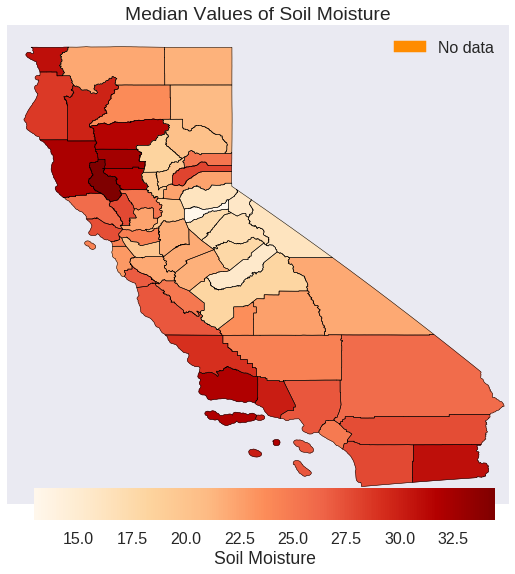

In [524]:
# Map of median values of soil moisture by counties

m = Basemap(llcrnrlon=min(data.variables["lon"][:]), llcrnrlat=min(data.variables["lat"][:])+1, 
              urcrnrlon=max(data.variables["lon"][:])-8.5, urcrnrlat=max(data.variables["lat"][:])-10.5)
ax = plt.gca() 
fig = plt.gcf()
shp_info = m.readshapefile(shp[:-4],'Counties',drawbounds=True)

nodata_color = "darkorange"
colors={}
County_names=[]
patches = []

cmap = plt.cm.OrRd #binary, summer https://matplotlib.org/users/colormaps.html 
vmin = min(medians); vmax = max(medians)
norm = Normalize(vmin=vmin, vmax=vmax)

# color mapper to covert values to colors
mapper = ScalarMappable(norm=norm, cmap=cmap)

for shapedict in m.Counties_info:
    County_name = shapedict['NAMELSAD']
    County_name = County_name[:-7]
    if County_name in medians_dict:
        value = medians_dict[County_name]
        colors[County_name] = mapper.to_rgba(value)
        County_names.append(County_name)
    else:
        County_names.append(County_name)
        colors[County_name] = nodata_color

for nshape,seg in enumerate(m.Counties):
    color = rgb2hex(colors[County_names[nshape]]) 
    poly = Polygon(seg,facecolor=color,edgecolor=color)
    if (colors[County_names[nshape]] == nodata_color):
        p_no = poly
    ax.add_patch(poly)
    
plt.title('Median Values of Soil Moisture')

# put legend for no data states
if p_no is not None:
    plt.legend((p_no,), ('No data',))

# construct custom colorbar
cax = fig.add_axes([0.27, 0.1, 0.5, 0.05]) # posititon
cb = ColorbarBase(cax,cmap=cmap,norm=norm, orientation='horizontal')
cb.ax.set_xlabel('Soil Moisture')
plt.show()

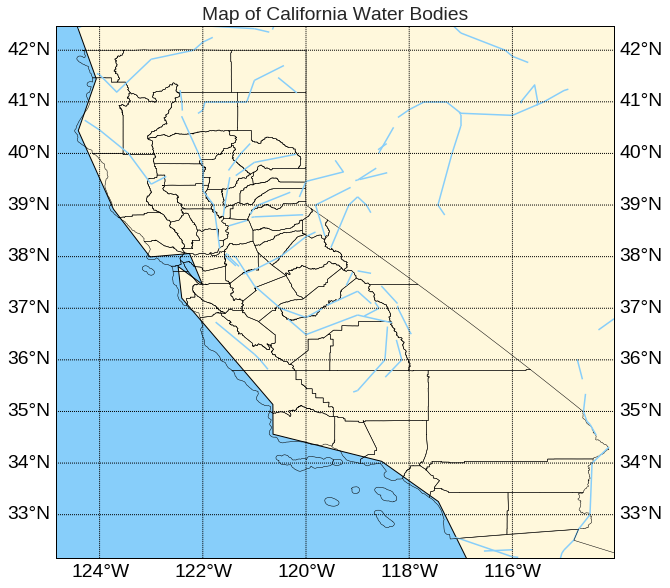

In [544]:
# California Water Bodies
water = 'lightskyblue'
earth = 'cornsilk'
juneau_lon, juneau_lat = -124.4167, 38.3
fig, ax1 = plt.subplots(figsize=(10, 10))

mm = Basemap(llcrnrlon=min(data.variables["lon"][:]), llcrnrlat=min(data.variables["lat"][:])+1, 
              urcrnrlon=max(data.variables["lon"][:])-8.5, urcrnrlat=max(data.variables["lat"][:])-10.5)

shp_info = mm.readshapefile(shp[:-4],'Counties',drawbounds=True)


coast = mm.drawcoastlines()
rivers = mm.drawrivers(color=water, linewidth=1.5)
continents = mm.fillcontinents(color=earth,lake_color=water)
bound= mm.drawmapboundary(fill_color=water)
countries = mm.drawcountries()
merid = mm.drawmeridians(np.arange(-180, 180, 2), labels=[False, False, False, True])
parall = mm.drawparallels(np.arange(0, 80), labels=[True, True, False, False])
#x, y = mm(juneau_lon, juneau_lat)
#juneau = mm.scatter(x, y, 80, label="Juneau", color='red', zorder=10)
plt.title("Map of California Water Bodies")

In [555]:
# GDAL command line operations (file conversions, setting projection, etc.)

In [556]:
# Use GDAL functions to convert .asc to .tif, set projection, clip raster with polygon
'gdal_translate -of "GTiff" sm.asc sm.tif'
"gdalinfo sm.tif"
# https://gis.stackexchange.com/questions/65998/how-can-i-use-gdal-to-batch-define-a-projection
"gdalwarp -t_srs EPSG:4326 -te -124.8437500 31.1562500 -105.4687500 53.0312500 sm.tif sm_wgs84.tif"
"gdalwarp -cutline /home2/svimal/Github/CA_drought/data/Spatial/CA_counties/CA_counties_WGS.shp -crop_to_cutline -dstalpha sm_wgs84.tif sm_clipped.tif"

'gdalwarp -cutline /home2/svimal/Github/CA_drought/data/Spatial/CA_counties/CA_counties_WGS.shp -crop_to_cutline -dstalpha sm_wgs84.tif sm_clipped.tif'